In [1]:
!git clone https://github.com/Tanveer2719/NIDS_Coursework.git
%cd /kaggle/working/NIDS_Coursework/My_Code

Cloning into 'NIDS_Coursework'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 248 (delta 125), reused 207 (delta 84), pack-reused 0 (from 0)
Receiving objects: 100% (248/248), 205.71 KiB | 10.29 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/kaggle/working/NIDS_Coursework/My_Code


In [2]:
!ls /kaggle/input

nslkdd


In [3]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(42)


2025-08-04 06:09:18.667635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754287758.887458      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754287758.961950      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import pandas as pd
import numpy as np

url_train = "/kaggle/input/nslkdd/KDDTrain+.txt"
url_test = "/kaggle/input/nslkdd/KDDTest+.txt"
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'attack', 'level'
]

train_df = pd.read_csv(url_train, names=columns)
test_df = pd.read_csv(url_test, names=columns)


# Drop the "type" column (not needed)
train_df.drop(columns=['level'], inplace=True)
test_df.drop(columns=['level'], inplace=True)

# Strip whitespace from class labels
for df in [train_df, test_df]:
    df['attack'] = df['attack'].str.strip()



# Combine train and test
full_df = pd.concat([train_df, test_df], ignore_index=True)

full_df['label'] = full_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)
full_df = full_df.drop(columns=['attack'])

print(f'full_df.shape : {full_df.shape}')




# --------------------------- perform preprocessing--------------

from preprocess import Preprocess

# separate the features and labels so that the labesl are not encoded
labels = full_df['label']
features = full_df.drop(columns=['label'])

pp = Preprocess()
processed_features = pp.fit_transform_df_auto(df = features,n_categorical_levels=32, expected_categorical_format='onehot')

print(processed_features.shape)

# concat the features and the labels
processed_full_df = pd.concat([processed_features, labels], axis=1)


full_df.shape : (148517, 42)
Encoding the 3 levels for protocol_type
Encoding the 32 levels for service
Encoding the 11 levels for flag
(148517, 84)


In [5]:
# Filter out categorical one-hot encoded columns
numerical_columns = [col for col in processed_full_df 
                     if not (col.startswith("protocol_type_") or 
                             col.startswith("service_") or 
                             col.startswith("flag_") or
                             col == 'label')]

numerical_columns


['duration',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [6]:
target = processed_full_df['label']
features = processed_full_df.drop(columns=['label'])

In [7]:
from record_level_embedding import RecordLevelEmbedder

embedder = RecordLevelEmbedder(selected_df = features, numerical_columns = numerical_columns, embed_dimension= 64)

embedded_df = embedder.transform_to_df()
embedded_df.head()

[INFO] Initializing RecordLevelEmbedder...
[INFO] Detecting categorical blocks...
[INFO] Detected 3 categorical blocks:
   - protocol_type: 3 columns
   - service: 32 columns
   - flag: 11 columns
[INFO] Embedder initialized with embedding dimension 64.
[INFO] Building Keras embedding model...
   - Adding numerical input: duration
   - Adding numerical input: src_bytes
   - Adding numerical input: dst_bytes
   - Adding numerical input: land
   - Adding numerical input: wrong_fragment
   - Adding numerical input: urgent
   - Adding numerical input: hot
   - Adding numerical input: num_failed_logins
   - Adding numerical input: logged_in
   - Adding numerical input: num_compromised
   - Adding numerical input: root_shell
   - Adding numerical input: su_attempted
   - Adding numerical input: num_root
   - Adding numerical input: num_file_creations
   - Adding numerical input: num_shells
   - Adding numerical input: num_access_files
   - Adding numerical input: num_outbound_cmds
   - Addin

I0000 00:00:1754287773.122413      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754287773.123098      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


[INFO] Projection complete. Output embedding shape: (64,)
[INFO] Model build complete.
[INFO] Preparing inputs for embedding. Number of rows: 148517
   - Prepared numerical input: duration
   - Prepared numerical input: src_bytes
   - Prepared numerical input: dst_bytes
   - Prepared numerical input: land
   - Prepared numerical input: wrong_fragment
   - Prepared numerical input: urgent
   - Prepared numerical input: hot
   - Prepared numerical input: num_failed_logins
   - Prepared numerical input: logged_in
   - Prepared numerical input: num_compromised
   - Prepared numerical input: root_shell
   - Prepared numerical input: su_attempted
   - Prepared numerical input: num_root
   - Prepared numerical input: num_file_creations
   - Prepared numerical input: num_shells
   - Prepared numerical input: num_access_files
   - Prepared numerical input: num_outbound_cmds
   - Prepared numerical input: is_host_login
   - Prepared numerical input: is_guest_login
   - Prepared numerical input: 

2025-08-04 06:09:34.628740: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_54}}


4642/4642 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
[INFO] Embedding complete. Output shape: (148517, 64)
[INFO] Embedding DataFrame ready.


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,-0.098493,-0.430934,0.356486,0.426960,-0.463572,0.073718,0.293909,-0.464140,0.118659,-0.262376,...,0.298373,0.333528,-0.001059,0.080013,-0.433949,-0.174244,0.163433,0.206417,0.356304,0.250252
1,-0.079922,-0.581097,0.231248,-0.188682,-0.378036,0.064248,0.267324,-0.222029,0.255809,-0.392803,...,-0.032528,-0.021862,-0.004445,0.335228,-0.047893,-0.077679,0.243481,0.377111,0.210872,-0.385815
2,-0.262571,-0.318067,0.165039,-0.020082,-0.589385,0.437861,0.663747,-0.615770,0.431340,-0.297033,...,0.562694,-0.113697,0.106212,-0.672360,-0.463417,-0.290735,-0.298873,0.189061,0.433069,0.164508
3,0.223863,-0.365672,0.692230,0.682934,-0.120872,0.157251,0.144474,-0.427487,0.095715,-0.506520,...,0.110611,-0.023379,0.137974,-0.305951,-0.748422,0.103043,0.291478,0.471077,0.570019,-0.042804
4,0.179632,-0.427639,0.750690,0.715394,-0.115504,0.111374,0.211843,-0.482872,0.170056,-0.701176,...,0.133799,0.020393,0.027257,-0.147716,-0.857315,0.124030,0.239708,0.472894,0.643264,0.011807


In [8]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

print(processed_full_df['label'].unique())

binary_target = (processed_full_df['label'] != 0).astype(int).values
unique, counts = np.unique(binary_target, return_counts=True)
print("Classes and their counts:")
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt}")

X_embed = embedded_df.values.astype(np.float32)  # shape: (num_samples, input_dim)
X_embed_seq = tf.expand_dims(X_embed, axis=1)  # shape: (batch_size, 1, embed_dim)
print(f"X_embed_seq : {X_embed_seq.shape}")

X_np = X_embed_seq.numpy() if hasattr(X_embed_seq, 'numpy') else np.array(X_embed_seq)

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_np, binary_target, test_size=0.2, stratify=binary_target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


[0 1]
Classes and their counts:
Class 0: 77054
Class 1: 71463
X_embed_seq : (148517, 1, 64)
X_train: (95050, 1, 64)
y_train: (95050,)
X_val: (23763, 1, 64)
y_val: (23763,)
X_test: (29704, 1, 64)
y_test: (29704,)


## FlowTransformer

In [16]:
from CustomTransformer import TransformerBinaryClassifier
# Prepare inputs
input_shape = (1, X_embed.shape[1])

# Initialize model wrapper
model = TransformerBinaryClassifier(input_shape=input_shape)

# Print model summary
model.summary()

# Train
model.train(
    X_train, y_train,
    X_val, y_val,
    batch_size=32,
    epochs=50,
    patience=5
)




Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ record_input (InputLayer)       │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_0_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ slice_last (Lambda)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_mlp_0_128        │ (None, 128)            │         8,320 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ binary_output (Dense)           │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,457 (1.17 MB)

 Trainable params: 307,457 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-08-04 06:30:39.257752: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


2970/2971 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9553 - loss: 0.1141

2025-08-04 06:31:20.850348: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9553 - loss: 0.1141 - val_accuracy: 0.9735 - val_loss: 0.0661
Epoch 2/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9759 - loss: 0.0640 - val_accuracy: 0.9814 - val_loss: 0.0488
Epoch 3/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9790 - loss: 0.0553 - val_accuracy: 0.9864 - val_loss: 0.0444
Epoch 4/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9827 - loss: 0.0478 - val_accuracy: 0.9855 - val_loss: 0.0421
Epoch 5/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9850 - loss: 0.0436 - val_accuracy: 0.9903 - val_loss: 0.0321
Epoch 6/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9868 - loss: 0.0388 - val_accuracy: 0.9893 - val_loss: 0.0337
Epoch 7/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9875 - loss: 0.0372 - val_accuracy: 0.9891 - val_loss: 0.0354
Epoch 8/50
2971/2971 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9879 - loss: 0.03

## GAN

In [17]:
#  PGD code
@tf.function
def pgd_attack_tf_fast(model, x, y, epsilon=0.05, alpha=0.01, num_iter=10, clip_min=-1.5, clip_max=1.5):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.cast(tf.reshape(y, (-1, 1)), tf.float32)
    x_orig = tf.identity(x)
    x_adv = tf.identity(x)

    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            logits = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(y, logits)

        # Normalize gradient
        grad = tape.gradient(loss, x_adv)
        signed_grad = tf.sign(grad)
        x_adv = x_adv + alpha * signed_grad
        x_adv = tf.clip_by_value(x_adv, x_orig - epsilon, x_orig + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv


In [19]:
X_adv_train = pgd_attack_tf_fast(model.model, X_train, y_train)
print(f"X_adv_train shape: {X_adv_train.shape}")
X_adv_val = pgd_attack_tf_fast(model.model, X_val, y_val)
print(f"X_adv_val shape: {X_adv_val.shape}")

X_adv_train shape: (95050, 1, 64)
X_adv_val shape: (23763, 1, 64)


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from GAN import Generator,Discriminator,GANPurifier

# Instantiate models
generator = Generator()
discriminator = Discriminator()
gan = GANPurifier(generator, discriminator, lambda_adv=0.5)

# Compile model
gan.compile()

# Build training dataset
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_adv_train))
train_dataset = train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

early_stop = EarlyStopping(
    monitor="cosine_similarity",
    mode="max",              # Since higher cosine similarity is better
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)


# Train with early stopping
gan.fit(train_dataset, epochs=100, callbacks=[early_stop])


Epoch 1/100


I0000 00:00:1754290594.756609     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - cosine_similarity: 0.0997 - d_loss: 1.2280 - g_loss: 1.0064 - reconstruction_loss: 0.5841
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - cosine_similarity: 0.3666 - d_loss: 1.0814 - g_loss: 0.7209 - reconstruction_loss: 0.3150
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - cosine_similarity: 0.6228 - d_loss: 1.1164 - g_loss: 0.5677 - reconstruction_loss: 0.2009
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - cosine_similarity: 0.8024 - d_loss: 1.3350 - g_loss: 0.4772 - reconstruction_loss: 0.1381
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - cosine_similarity: 0.8887 - d_loss: 1.4432 - g_loss: 0.4638 - reconstruction_loss: 0.1089
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - cosine_similarity: 0.9113 - d_loss: 1.4772 - g_loss: 0.4687 - reconstruction_loss: 0.1003
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - cosine_similarity: 0.9185 - d_loss: 1.4251 - g_loss: 0.4682 - reconstruction_los

In [23]:
# test the gan
# Generate adversarial examples

print(f"X_adv_val shape: {X_adv_val.shape}")

# Purify them using your generator
x_purified_val = generator(X_adv_val, training=False)


# L1 (Mean Absolute Error)
l1_loss = tf.reduce_mean(tf.abs(X_val - x_purified_val))

# L2 (Mean Squared Error)
l2_loss = tf.reduce_mean(tf.square(X_val - x_purified_val))

x_purified_val = generator(X_adv_val, training=False)

X_val_norm = tf.nn.l2_normalize(tf.squeeze(X_val, axis=1), axis=1)
x_purified_norm = tf.nn.l2_normalize(tf.squeeze(x_purified_val, axis=1), axis=1)
cos_sim = tf.reduce_mean(tf.reduce_sum(X_val_norm * x_purified_norm, axis=1))
print(f"Normalized Cosine Similarity: {cos_sim:.6f}")



print(f"🧪 Purifier Evaluation Metrics:")
print(f"✅ Corrected Cosine Similarity: {cos_sim:.6f}")
print(f"   ➤ L1 Loss (MAE):         {l1_loss:.6f}")
print(f"   ➤ L2 Loss (MSE):         {l2_loss:.6f}")


X_adv_val shape: (23763, 1, 64)
Normalized Cosine Similarity: 0.983546
🧪 Purifier Evaluation Metrics:
✅ Corrected Cosine Similarity: 0.983546
   ➤ L1 Loss (MAE):         0.036042
   ➤ L2 Loss (MSE):         0.003527


## Check the model performance using crafted Test set

In [24]:
import tensorflow as tf

@tf.function
def fgsm_attack_tf(model, inputs, labels, epsilon=0.05, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs, training=False)
        loss = tf.keras.losses.binary_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)

    gradients = tape.gradient(loss, inputs)
    signed_grad = tf.sign(gradients)
    x_adv = inputs + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)
    return x_adv


@tf.function
def pgd_attack_tf(model, inputs, labels, epsilon=0.05, alpha=0.01, num_iter=10, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    x_adv = tf.identity(inputs)

    for _ in tf.range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            predictions = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, predictions)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(gradients)
        x_adv = tf.clip_by_value(x_adv, inputs - epsilon, inputs + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv


@tf.function
def mi_fgsm_attack(model, inputs, labels, epsilon=0.05, alpha=0.01, steps=40, decay=1.0, clip_min=-1.5, clip_max=1.5):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    labels = tf.reshape(tf.convert_to_tensor(labels, dtype=tf.float32), (-1, 1))

    x_adv = tf.identity(inputs)
    g = tf.zeros_like(inputs)

    for _ in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            logits = model(x_adv, training=False)
            loss = tf.keras.losses.binary_crossentropy(labels, logits)
            loss = tf.reduce_mean(loss)

        grad = tape.gradient(loss, x_adv)
        # Normalize gradient
        grad_norm = tf.reduce_mean(tf.abs(grad), axis=list(range(1, len(grad.shape))), keepdims=True)
        grad = grad / (grad_norm + 1e-8)

        g = decay * g + grad
        x_adv = x_adv + alpha * tf.sign(g)
        x_adv = tf.clip_by_value(x_adv, inputs - epsilon, inputs + epsilon)
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

    return x_adv



from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def evaluate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        numerator = tp * tn - fp * fn
        denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = numerator / (denominator + 1e-10)
        specificity = tn / (tn + fp + 1e-10)
        balanced_acc = (recall + specificity) / 2
    else:
        mcc = 0
        balanced_acc = 0
        specificity = 0

    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc,
        'specificity': specificity,
        'balanced_accuracy': balanced_acc
    }



In [25]:
def evaluate_model(model, generator, adv_model, X, y, epsilon_list=[0.01, 0.03, 0.05, 0.07]):
    import tensorflow as tf
    import numpy as np

    X_clean = X
    x_clean_tf = tf.convert_to_tensor(X_clean, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)

    # ----------- Clean Data Evaluation (no adversarial) -----------
    print("✅ Clean Evaluation (GAN purified):")
    x_purified_clean = generator(x_clean_tf, training=False)
    y_pred_clean_prob = adv_model.predict(x_purified_clean)
    y_pred_clean = (y_pred_clean_prob > 0.5).astype(int).flatten()
    clean_metrics = evaluate_metrics(y, y_pred_clean)
    print(f"Clean → F1: {clean_metrics['f1']:.4f}, Precision: {clean_metrics['precision']:.4f}, Recall: {clean_metrics['recall']:.4f}, MCC: {clean_metrics.get('mcc', 'N/A')}, Specificity: {clean_metrics.get('specificity', 'N/A')}, Balanced Acc: {clean_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- FGSM Attack Evaluation -----------
    print("\nFGSM Attack Evaluation with GAN Purification")
    fgsm_results = []
    for eps in epsilon_list:
        x_adv = fgsm_attack_tf(model, x_clean_tf, y_tf, epsilon=eps )
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        x_purified = generator(x_adv_tf, training=False)
        y_pred_prob = adv_model.predict(x_purified)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        fgsm_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- PGD Attack Evaluation -----------
    print("\nPGD Attack Evaluation with GAN Purification:")
    pgd_results = []
    for eps in epsilon_list:
        alpha = eps * 0.2
        x_adv = pgd_attack_tf(model, x_clean_tf, y_tf, epsilon=eps, alpha=alpha, num_iter=10)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        x_purified = generator(x_adv_tf, training=False)
        y_pred_prob = adv_model.predict(x_purified )
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        pgd_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  PGD ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    # ----------- MI-FGSM Attack Evaluation -----------
    print("\nMI-FGSM Attack Evaluation with GAN Purification:")
    mifgsm_results = []
    for eps in epsilon_list:
        alpha = eps * 0.2
        steps = 10
        decay = 1.0

        x_adv = mi_fgsm_attack(model, x_clean_tf, y_tf, epsilon=eps, alpha=alpha, steps=steps, decay=decay)
        x_adv_tf = tf.convert_to_tensor(x_adv.numpy(), dtype=tf.float32)
        x_purified = generator(x_adv_tf, training=False)
        y_pred_prob = adv_model.predict(x_purified )
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        adv_metrics = evaluate_metrics(y, y_pred)
        mifgsm_results.append({'epsilon': eps, 'adversarial': adv_metrics})

        print(f"  MI-FGSM ε={eps:.2f} → F1: {adv_metrics['f1']:.4f}, Precision: {adv_metrics['precision']:.4f}, Recall: {adv_metrics['recall']:.4f}, MCC: {adv_metrics.get('mcc', 'N/A')}, Specificity: {adv_metrics.get('specificity', 'N/A')}, Balanced Acc: {adv_metrics.get('balanced_accuracy', 'N/A')}")

    return fgsm_results, pgd_results, mifgsm_results


## PGD Adversarially trained model

In [26]:
from Adversarial_Transformer import PGDAdversarialTrainer,PGDTransformerClassifier

transformer_config = {
    "n_layers": 2,
    "internal_size": 128,
    "n_heads": 4,
    "verbose": False
}

pgd_config = {
    "epsilon_range": (0.01, 0.1),
    "alpha": 0.01,
    "num_iter": 7
}

clf = PGDTransformerClassifier(
    input_dim=X_embed.shape[1],
    transformer_config=transformer_config,
    pgd_config=pgd_config
)

clf.compile_and_wrap(optimizer=tf.keras.optimizers.Adam())
clf.summary()

clf.fit(X_train, y_train, X_val, y_val, batch_size=64, epochs=10)



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ record_input (InputLayer)       │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_0_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_transformer_encoder     │ (None, 1, 64)          │       149,504 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ slice_last (Lambda)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_0 (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,457 (1.17 MB)

 Trainable params: 307,457 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1485/1486 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9305 - loss: 0.1348

2025-08-04 07:26:37.812877: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1486/1486 ━━━━━━━━━━━━━━━━━━━━ 86s 40ms/step - accuracy: 0.9306 - loss: 0.1346 - val_accuracy: 0.9784 - val_loss: 0.0290
Epoch 2/10
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.9565 - loss: 0.1100 - val_accuracy: 0.9837 - val_loss: 0.0568
Epoch 3/10
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.9619 - loss: 0.0980 - val_accuracy: 0.9859 - val_loss: 0.0393
Epoch 4/10
1486/1486 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9635 - loss: 0.0936 - val_accuracy: 0.9877 - val_loss: 0.0561


In [27]:
fgsm_full, pgd_full, mi_full = evaluate_model(model= clf.model,generator=generator,adv_model=clf.model, X = X_test, y = y_test)

malicious_mask = (y_test == 1)
X_malicious = X_test[malicious_mask]
y_malicious = y_test[malicious_mask]
fgsm_mal, pgd_mal, mi_mal = evaluate_model(model= clf.model,generator=generator,adv_model=clf.model, X = X_malicious, y = y_malicious)

✅ Clean Evaluation (GAN purified):


2025-08-04 07:29:36.107149: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Clean → F1: 0.9604, Precision: 0.9675, Recall: 0.9535, MCC: 0.9243303544606105, Specificity: 0.9702809681396343, Balanced Acc: 0.9618773482690754

FGSM Attack Evaluation with GAN Purification
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  FGSM ε=0.01 → F1: 0.9559, Precision: 0.9604, Recall: 0.9514, MCC: 0.9153886699688861, Specificity: 0.9636623191226983, Balanced Acc: 0.9575185589876417
 78/929 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2025-08-04 07:29:43.624999: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  FGSM ε=0.03 → F1: 0.9510, Precision: 0.9555, Recall: 0.9465, MCC: 0.9059453309022228, Specificity: 0.9591201090130365, Balanced Acc: 0.9527987027958906
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  FGSM ε=0.05 → F1: 0.9433, Precision: 0.9479, Recall: 0.9388, MCC: 0.8913089884649439, Specificity: 0.9521770164168389, Balanced Acc: 0.9454791189969174
 78/929 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2025-08-04 07:29:50.354849: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  FGSM ε=0.07 → F1: 0.9337, Precision: 0.9373, Recall: 0.9301, MCC: 0.8726872060362627, Specificity: 0.9423139316072874, Balanced Acc: 0.936209788863883

PGD Attack Evaluation with GAN Purification:
 77/929 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2025-08-04 07:29:56.369671: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  PGD ε=0.01 → F1: 0.9560, Precision: 0.9606, Recall: 0.9514, MCC: 0.9155913775017658, Specificity: 0.9637920965544029, Balanced Acc: 0.9576184298625929
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  PGD ε=0.03 → F1: 0.9512, Precision: 0.9549, Recall: 0.9475, MCC: 0.9062759122141657, Specificity: 0.9584712218545133, Balanced Acc: 0.952998991603112
 78/929 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2025-08-04 07:30:06.329111: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  PGD ε=0.05 → F1: 0.9424, Precision: 0.9463, Recall: 0.9386, MCC: 0.8894151712017013, Specificity: 0.9505547985205312, Balanced Acc: 0.9445630635714668
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  PGD ε=0.07 → F1: 0.9284, Precision: 0.9322, Recall: 0.9246, MCC: 0.862503353148954, Specificity: 0.9376419440659208, Balanced Acc: 0.9311102045243898

MI-FGSM Attack Evaluation with GAN Purification:
 80/929 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2025-08-04 07:30:16.360664: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  MI-FGSM ε=0.01 → F1: 0.9560, Precision: 0.9607, Recall: 0.9514, MCC: 0.9156591847880865, Specificity: 0.9638569852702552, Balanced Acc: 0.957650874220519
 78/929 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2025-08-04 07:30:21.446327: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  MI-FGSM ε=0.03 → F1: 0.9511, Precision: 0.9552, Recall: 0.9470, MCC: 0.9061438976794566, Specificity: 0.9587956654337748, Balanced Acc: 0.9529163382790506
 74/929 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2025-08-04 07:30:26.477809: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  MI-FGSM ε=0.05 → F1: 0.9414, Precision: 0.9456, Recall: 0.9372, MCC: 0.8875291008348138, Specificity: 0.9500356887937126, Balanced Acc: 0.9436038655260803
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
  MI-FGSM ε=0.07 → F1: 0.9279, Precision: 0.9290, Recall: 0.9267, MCC: 0.86115886737931, Specificity: 0.9343326195574528, Balanced Acc: 0.9305399892022204
✅ Clean Evaluation (GAN purified):
 78/447 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-04 07:30:33.727501: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Clean → F1: 0.9762, Precision: 1.0000, Recall: 0.9535, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.47673686419925837

FGSM Attack Evaluation with GAN Purification
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  FGSM ε=0.01 → F1: 0.9751, Precision: 1.0000, Recall: 0.9514, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.47568739942629257
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  FGSM ε=0.03 → F1: 0.9725, Precision: 1.0000, Recall: 0.9465, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4732386482893724
 79/447 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-04 07:30:40.081932: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  FGSM ε=0.05 → F1: 0.9684, Precision: 1.0000, Recall: 0.9388, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.46939061078849786
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  FGSM ε=0.07 → F1: 0.9638, Precision: 1.0000, Recall: 0.9301, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.46505282306023926

PGD Attack Evaluation with GAN Purification:
 78/447 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-04 07:30:45.179752: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  PGD ε=0.01 → F1: 0.9751, Precision: 1.0000, Recall: 0.9514, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.47572238158539143
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  PGD ε=0.03 → F1: 0.9731, Precision: 1.0000, Recall: 0.9475, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.47376338067585533
 77/447 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-04 07:30:51.143527: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  PGD ε=0.05 → F1: 0.9683, Precision: 1.0000, Recall: 0.9386, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4692856643112013
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  PGD ε=0.07 → F1: 0.9608, Precision: 1.0000, Recall: 0.9246, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4622892324914294

MI-FGSM Attack Evaluation with GAN Purification:
 77/447 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-04 07:30:57.088660: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  MI-FGSM ε=0.01 → F1: 0.9751, Precision: 1.0000, Recall: 0.9514, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.47572238158539143
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  MI-FGSM ε=0.03 → F1: 0.9728, Precision: 1.0000, Recall: 0.9470, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4735185055621633
 77/447 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-04 07:31:03.070072: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  MI-FGSM ε=0.05 → F1: 0.9676, Precision: 1.0000, Recall: 0.9372, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.4685860211292241
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  MI-FGSM ε=0.07 → F1: 0.9620, Precision: 1.0000, Recall: 0.9267, MCC: 0.0, Specificity: 0.0, Balanced Acc: 0.463373679423494


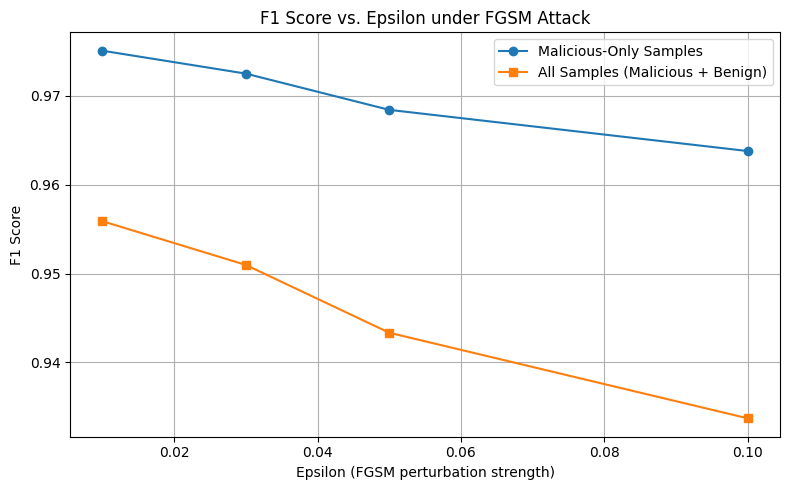

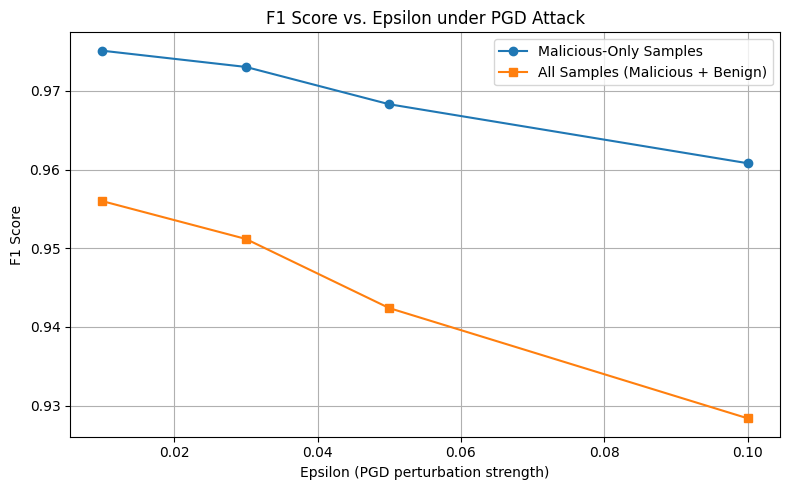

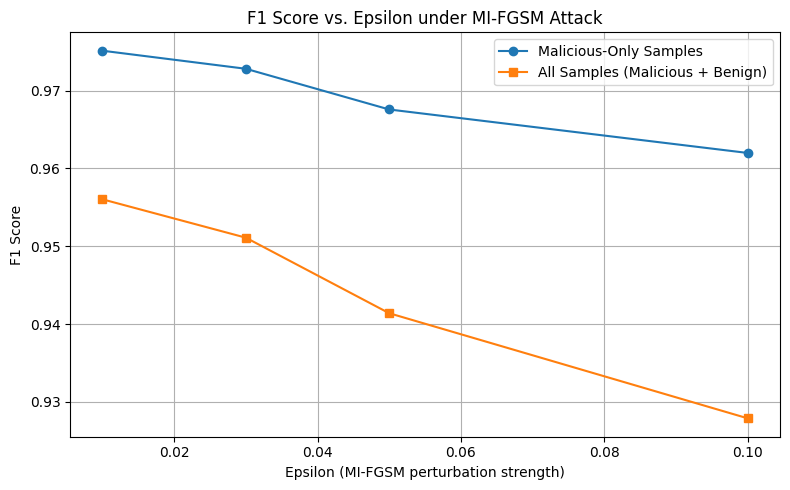

In [28]:
import matplotlib.pyplot as plt

def plot_results(f1_malicious_list, f1_all_list, epsilons, a_type="PGD"):
    plt.figure(figsize=(8, 5))
    plt.plot(epsilons, f1_malicious_list, marker='o', label='Malicious-Only Samples')
    plt.plot(epsilons, f1_all_list, marker='s', label='All Samples (Malicious + Benign)')
    plt.xlabel(f"Epsilon ({a_type} perturbation strength)")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score vs. Epsilon under {a_type} Attack")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

f1_malicious_scores = [entry['adversarial']['f1'] for entry in fgsm_mal]
f1_all_scores = [entry['adversarial']['f1'] for entry in fgsm_full]
plot_results(f1_malicious_scores, f1_all_scores, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='FGSM')


f1_malicious_scores_pgd = [entry['adversarial']['f1'] for entry in pgd_mal]
f1_all_scores_pgd = [entry['adversarial']['f1'] for entry in pgd_full]

plot_results(f1_malicious_scores_pgd, f1_all_scores_pgd, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='PGD')

f1_malicious_scores_mi = [entry['adversarial']['f1'] for entry in mi_mal]
f1_all_scores_mi = [entry['adversarial']['f1'] for entry in mi_full]

plot_results(f1_malicious_scores_mi, f1_all_scores_mi, epsilons=[0.01, 0.03, 0.05, 0.1], a_type='MI-FGSM')

